In [30]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from collections import defaultdict
import re
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import time
import itertools
import random

### Linear Regression Approach

In [31]:
def get_stock_data(ticker, start_date, end_date, frequency='1d'):
    """
    Get stock data from Yahoo Finance.
    
    :param ticker: Stock ticker symbol.
    :param start_date: Start date for the data in 'YYYY-MM-DD' format.
    :param end_date: End date for the data in 'YYYY-MM-DD' format.
    :param frequency: Data frequency ('1d' for daily, '1wk' for weekly, '1mo' for monthly). Default is daily.
    :return: DataFrame with stock data.
    """

    # Fetch data
    stock_data = yf.Ticker(ticker)
    hist_data = stock_data.history(start=start_date, end=end_date, interval=frequency)
    
    # Create DataFrame for Close prices
    raw_data = pd.DataFrame(hist_data['Close'])

    return raw_data

def clean_data(raw_data):
    """
    Clean data.
    """
    raw_data.dropna(inplace=True)
    raw_data.reset_index(drop=True, inplace=True)
    raw_data_np = raw_data.values.reshape((-1, 1))
    return raw_data_np

def get_training_data(arr, start_idx, train_size):
    """
    Get training data.
    """

    return arr[start_idx:start_idx + train_size, :]

def train_model(y):
    """
    Train the model.
    """
    x = np.arange(y.shape[0]).reshape((-1, 1))

    model = LinearRegression()
    model.fit(x, y)
    slope = model.coef_[0]

    return model, slope

def plot_tmp(raw_data_np, preds_saved, balance_list, i):
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.scatter(np.arange(i), preds_saved[:i, :], s=1.0, c='r')
    ax.plot(raw_data_np[:i, :])
    ax2 = ax.twinx()
    ax2.plot(balance_list, c='g', linewidth=1.0, linestyle='dashed')
    ax.set_ylim((1.0, max(raw_data_np[:i, :])))
    plt.show()

def kl_divergence(p, q):
    """
    Calculate the Kullback-Leibler divergence between two probability distributions.
    Both p and q should be numpy arrays of the same length, and they should sum to 1.
    """
    # Filter out zero values from p and corresponding elements in q to avoid division by zero
    nonzero_indices = p > 0
    p = p[nonzero_indices]
    q = q[nonzero_indices]

    # Calculate KL divergence
    return np.sum(p * np.log(p / q))



In [32]:
class TradeManager:
    def __init__(self, balance, position_percent=0.1):
        self.balance = balance
        self.position_percent = position_percent
        self.profit = 0.0
        self.trade_log = []
        self.reset()
        
    def reset(self):
        self.units_held = 0
        self.buy_price = None
        self.long = None
        self.in_trade = False

    def enter_trade(self, buy_price, long):
        self.buy_price = buy_price
        self.units_held = (self.balance * self.position_percent) / buy_price
        self.long = long
        self.in_trade = True

    def exit_trade(self, sell_price):
        if self.long:
            profit = (self.units_held * sell_price) - (self.units_held * self.buy_price)
        else:
            profit = -(self.units_held * sell_price) + (self.units_held * self.buy_price)
        self.balance += profit
        self.update_trade_log(sell_price, profit)
        self.reset()

    def update_trade_log(self, sell_price, profit):
        self.trade_log.append(f'type={self.long} entry price={self.buy_price} exit price={sell_price} profit={profit} balance={self.balance}')


In [72]:
def trade_test(data,
                window_size,
                start_balance,
                position_percent,
                min_slope_long,
                min_slope_short,
                std_factor):
    
    n = data.shape[0]
    tm = TradeManager(start_balance, position_percent)

    balance = start_balance
    balances = []
    preds = np.zeros_like(data)
    ubs = np.zeros_like(data)
    lbs = np.zeros_like(data)

    slope = [0.0]
    slopes = []
    long_entry = []
    short_entry = []
    trade_exit = []


    retrain = True

    for i in range(n):
        if i >= window_size:        
            y = get_training_data(data, i-window_size, window_size)
            if retrain:
                model, slope = train_model(y)
                slope = slope[0]
                y_std = y.std()
                retrain = False
                x_adj = 0

            x = np.arange(y.shape[0]).reshape((-1, 1)) + x_adj
            x_adj += 1
            
            y_preds = model.predict(x)

            y_t = data[i].item()
            y_pred_t = y_preds[-1].item()

            ubs_ = [y.item() + y_std * std_factor for y in y_preds]
            lbs_ = [y.item() - y_std * std_factor for y in y_preds]

            ub_t = ubs_[-1]
            lb_t = lbs_[-1]
            
            preds[i] = y_pred_t
            ubs[i] = ub_t
            lbs[i] = lb_t

            if tm.in_trade:
                if tm.long:
                    sl = max(sl, lb_t)
                else:
                    sl = min(sl, ub_t)

                if (tm.long and (y_t < sl or slope<0)) or (not tm.long and (y_t > sl or slope>0)) or i == (n - 1):
                    tm.exit_trade(y_t)
                    balance = tm.balance
                    retrain = True
                    trade_exit.append(y_t)
                else:
                    trade_exit.append(-1.0)
                long_entry.append(-1.0)
                short_entry.append(-1.0)
                
                    
            else:
                if slope > min_slope_long and y_t > lb_t and y_t < ub_t:
                    tm.enter_trade(y_t, True)
                    sl = lb_t
                    long_entry.append(y_t)
                    short_entry.append(-1.0)
                elif slope < min_slope_short and y_t < ub_t and y_t > lb_t:
                    tm.enter_trade(y_t, False)
                    sl = ub_t
                    short_entry.append(y_t)
                    long_entry.append(-1.0)
                else:
                    long_entry.append(-1.0)
                    short_entry.append(-1.0)
                trade_exit.append(-1.0)

            if y_t > ub_t or y_t < lb_t:
                retrain = True

            slopes.append(slope.item())
            balances.append(balance)

        else:
            slopes.append(0.0)
            balances.append(balance)
            long_entry.append(-1.0)
            short_entry.append(-1.0)
            trade_exit.append(-1.0)

    return balances, preds, ubs, lbs, slopes, long_entry, short_entry, trade_exit

def optimise(data, start_balance, position_percent, n_combinations=100, train_pct=0.8):
    # Define the ranges for a, b, and c
    window_range = range(5, 50, 1)  # Integer from 1 to 100
    slope_range = [round(i, 3) for i in itertools.takewhile(lambda x: x <= 3.0, itertools.count(0.001, 0.001))]  # Float from 0.1 to 1.0, step 0.001
    std_range = [round(i, 1) for i in itertools.takewhile(lambda x: x <= 2.0, itertools.count(0.5, 0.1))]  # Float from 1 to 2, step 0.1

    # Generate all possible combinations
    all_combinations = list(itertools.product(window_range, slope_range, std_range))

    # Randomly select N unique combinations
    if n_combinations <= len(all_combinations):
        random_combinations = random.sample(all_combinations, n_combinations)
    else:
        raise ValueError("N is larger than the total number of unique combinations")
    
    train_size =  int(len(data) * train_pct)
    train_data = data[:train_size, :]
    best_iteration = (-1, -1)
    for i, comb in enumerate(random_combinations):
        if i % 100 == 0:
            print(f'Iteration {i}')
        window_size = comb[0]
        min_slope_long = comb[1]
        min_slope_short = -comb[1]
        std_factor = comb[2]

        balances, _, _, _, _, _, _, _ = trade_test(train_data,
                window_size,
                start_balance,
                position_percent,
                min_slope_long,
                min_slope_short,
                std_factor
            )
        
        if balances[-1] > best_iteration[1]:
            print(i, balances[-1])
            best_iteration = (i, balances[-1])
    
    return random_combinations[best_iteration[0]]
    
# Create DataFrame with data
def create_df_for_plotting(raw_data_np,
                            preds,
                            lbs,
                            ubs,
                            long_entry,
                            short_entry,
                            trade_exit,
                            balances,
                            start_balance,
                            window_size
                            ):
    df = pd.DataFrame()
    df['x'] = np.arange(len(raw_data_np))
    df['y'] = raw_data_np
    df['y_preds'] = preds
    df['y_preds_lb'] = lbs
    df['y_preds_ub'] = ubs
    df['long_entry'] = long_entry
    df['short_entry'] = short_entry
    df['trade_exit'] = trade_exit
    df['balance'] = balances
    df['balance_bah'] = start_balance * np.cumprod(1.0 + pd.DataFrame(raw_data_np).pct_change().iloc[window_size:])
    df = df.iloc[window_size:]
    df['x'] = np.arange(len(raw_data_np)-window_size)
    df.reset_index(drop=True)

    return df

In [165]:
def create_plotly_plots(df):
        """
        Create plotly plots.
        """

        PAPER_BG_COLOR = '#010314'
        PLOT_BG_COLOR = '#C0BDC0' 
        FONT_COLOR = '#C0BDC0'
        GRID_COLOR = '#D9D7D9'
        
        min_x = df['x'].min()
        max_x = df['x'].max()
        min_y = df['y_preds_lb'].min()
        max_y = df['y_preds_ub'].max()

        # Plot the results using Plotly
        fig1 = go.Figure()

        # Prices
        fig1.add_trace(go.Scatter(x=df['x'], y=df['y'], name='Price', mode='lines', line=dict(width=1.0, color='magenta')))

        # Predictions
        fig1.add_trace(go.Scatter(x=df['x'], y=df['y_preds'], name='Predicted Price', mode='lines', line=dict(width=1.0, color='orange', dash='dot')))
        fig1.add_trace(go.Scatter(x=df['x'], y=df['y_preds_lb'], name='Lower Bound', mode='lines', line=dict(width=1.0, color='orange')))
        fig1.add_trace(go.Scatter(x=df['x'], y=df['y_preds_ub'], name='Upper Bound', mode='lines', line=dict(width=1.0, color='orange')))

        # Trade management
        fig1.add_trace(go.Scatter(x=df['x'], y=df['long_entry'], name='Long Entry', mode='markers', line=dict(width=1.0, color='green'), marker=dict(symbol='triangle-up')))
        fig1.add_trace(go.Scatter(x=df['x'], y=df['short_entry'], name='Short Entry', mode='markers', line=dict(width=1.0, color='red'), marker=dict(symbol='triangle-down')))
        fig1.add_trace(go.Scatter(x=df['x'], y=df['trade_exit'], name='Trade Exit', mode='markers', line=dict(width=1.0, color='blue'), marker=dict(symbol='cross')))

        fig1.update_layout(width=1000, 
                        height=600, 
                        paper_bgcolor=PAPER_BG_COLOR,
                        plot_bgcolor=PLOT_BG_COLOR,
                        font=dict(color=FONT_COLOR),
                        title='Price Predictions', 
                        yaxis_title='Price', 
                        xaxis=dict(range=[min_x, max_x], gridcolor=GRID_COLOR),
                        yaxis=dict(range=[min_y, max_y], gridcolor=GRID_COLOR),
                        legend ={'title_text': '',
                                'bgcolor': 'rgba(0,0,0,0)',
                                'orientation': 'h',
                                'yanchor': 'bottom',
                                'y': -0.2,
                                'xanchor': 'center',
                                'x': 0.5})


        fig1.show()

        # Plot the results using Plotly
        fig2 = go.Figure()

        # Balance
        fig2.add_trace(go.Scatter(x=df['x'], y=df['balance'], name='Balance (Active Trading)', mode='lines', line=dict(width=1.0, color='blue')))
        fig2.add_trace(go.Scatter(x=df['x'], y=df['balance_bah'], name='Balance (Buy and Hold)', mode='lines', line=dict(width=1.0, color='green')))
        fig2.update_layout(width=1000, 
                        height=300, 
                        paper_bgcolor=PAPER_BG_COLOR,
                        plot_bgcolor=PLOT_BG_COLOR,
                        font=dict(color=FONT_COLOR),
                        title='Balance', 
                        yaxis_title='Balance',
                        xaxis=dict(gridcolor=GRID_COLOR),
                        yaxis=dict(gridcolor=GRID_COLOR),
                        legend ={'title_text': '',
                                'bgcolor': 'rgba(0,0,0,0)',
                                'orientation': 'h',
                                'yanchor': 'bottom',
                                'y': -0.4,
                                'xanchor': 'center',
                                'x': 0.5}
                        )

        fig2.show()

        return fig1, fig2

In [166]:
# List of stock tickers
ticker = 'nvda'
WINDOW_SIZE = 5
START_BALANCE = 10000
POSITION_PERCENT = 1.0
MIN_SLOPE_LONG = 2.0
MIN_SLOPE_SHORT = -MIN_SLOPE_LONG
STD_FACTOR = 1.0

# Time period
start_date = pd.Timestamp('2020-01-01')
end_date = pd.Timestamp.now()

raw_data = get_stock_data(ticker, start_date, end_date, frequency='1d')
raw_data_np = clean_data(raw_data)

balances, preds, ubs, lbs, slopes, long_entry, short_entry, trade_exit = trade_test(raw_data_np,
                WINDOW_SIZE,
                START_BALANCE,
                POSITION_PERCENT,
                MIN_SLOPE_LONG,
                MIN_SLOPE_SHORT,
                STD_FACTOR)


In [167]:
slopes_df = pd.Series(slopes) 
slopes_df.describe(percentiles=[0.1, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])

count    981.000000
mean       0.565269
std        3.845495
min      -11.399066
5%        -5.977242
10%       -3.520712
25%       -1.187775
50%        0.428862
75%        2.303582
95%        6.412808
99%       11.225067
max       22.827756
dtype: float64

In [168]:
df = create_df_for_plotting(raw_data_np,
                            preds,
                            lbs,
                            ubs,
                            long_entry,
                            short_entry,
                            trade_exit,
                            balances,
                            START_BALANCE,
                            WINDOW_SIZE)

_ = create_plotly_plots(df)

In [83]:
best_parameters = optimise(raw_data_np, START_BALANCE, POSITION_PERCENT, n_combinations=1000, train_pct=0.6)

Iteration 0
0 8972.215670904714
4 15644.176990766631
19 16496.16042988903
52 20232.45662151954
Iteration 100
184 21265.78438285396
Iteration 200
216 23945.84841733403
Iteration 300
331 26111.839170380495
342 26368.942427493217
Iteration 400
Iteration 500
Iteration 600
645 28359.34059774038
Iteration 700
Iteration 800
Iteration 900


In [84]:
best_parameters

(7, 0.262, 1.2)

In [85]:
balances, preds, ubs, lbs, slopes, long_entry, short_entry, trade_exit = trade_test(raw_data_np,
                best_parameters[0],
                START_BALANCE,
                POSITION_PERCENT,
                best_parameters[1],
                -best_parameters[1],
                best_parameters[2])

df = create_df_for_plotting(raw_data_np,
                            preds,
                            lbs,
                            ubs,
                            long_entry,
                            short_entry,
                            trade_exit,
                            balances,
                            START_BALANCE,
                            best_parameters[0])

_ = create_plotly_plots(df)

In [90]:
df

,x,y,y_preds,y_preds_lb,y_preds_ub,long_entry,short_entry,trade_exit,balance,balance_bah
7,0,62.755314,60.608780,59.794537,61.423023,-1.000000,-1.0,-1.000000,10000.000000,10313.523438
8,1,61.584778,61.969209,60.486569,63.451849,61.584778,-1.0,-1.000000,10000.000000,10121.151666
9,2,61.158913,62.550382,61.067742,64.033023,-1.000000,-1.0,-1.000000,10000.000000,10051.162845
10,3,61.995716,63.131556,61.648915,64.614196,-1.000000,-1.0,-1.000000,10000.000000,10188.687324
11,4,62.082886,63.712729,62.230088,65.195369,-1.000000,-1.0,62.082886,10080.881661,10203.013222
...,...,...,...,...,...,...,...,...,...,...
976,969,494.799988,502.769616,483.195181,522.344052,-1.000000,-1.0,-1.000000,19220.570247,81317.914870
977,970,492.980011,510.345686,490.771250,529.920121,-1.000000,-1.0,-1.000000,19220.570247,81018.810742
978,971,504.089996,517.921755,498.347320,537.496190,-1.000000,-1.0,-1.000000,19220.570247,82844.681529
979,972,499.440002,525.497825,505.923389,545.072260,-1.000000,-1.0,499.440002,20982.101913,82080.478179


In [91]:
strategy_return = df['balance'].iloc[-1] / df['balance'].iloc[0] - 1
buy_and_hold_return = df['balance_bah'].iloc[-1] / df['balance_bah'].iloc[0] - 1
print(strategy_return, buy_and_hold_return)

1.0982101912798474 6.852404201610748


### Gaussian Mixture Model Approach

In [377]:
import numpy as np

def calculate_log_likelihood(samples, distribution):
    """
    Calculate the log likelihood of the samples under the given probability distribution.
    """
    likelihoods = distribution.pdf(samples)
    # Avoid log(0) by setting a very small value instead of zero
    likelihoods = np.where(likelihoods == 0, 1e-10, likelihoods)
    log_likelihood = np.sum(np.log(likelihoods))
    return log_likelihood

# Example probability distributions
from scipy.stats import norm

dist1 = norm(loc=0, scale=1)  # Normal distribution with mean 0 and std dev 1
dist2 = norm(loc=5, scale=2)  # Normal distribution with mean 5 and std dev 2
dist3 = norm(loc=-3, scale=1) # Normal distribution with mean -3 and std dev 1

# Generate 10 random numbers from one of these distributions
np.random.seed(0)  # For reproducibility
sample = dist2.rvs(size=10)

# Calculate log likelihood for each distribution
log_likelihood_1 = calculate_log_likelihood(sample, dist1)
log_likelihood_2 = calculate_log_likelihood(sample, dist2)
log_likelihood_3 = calculate_log_likelihood(sample, dist3)

# Determine which distribution most likely generated the sample
most_likely_distribution = np.argmax([log_likelihood_1, log_likelihood_2, log_likelihood_3]) + 1

print("Log Likelihoods:", log_likelihood_1, log_likelihood_2, log_likelihood_3)
print(f"The sample most likely came from Distribution {most_likely_distribution}")


Log Likelihoods: -237.59011042558873 -23.520459142810815 -476.87150066931883
The sample most likely came from Distribution 2


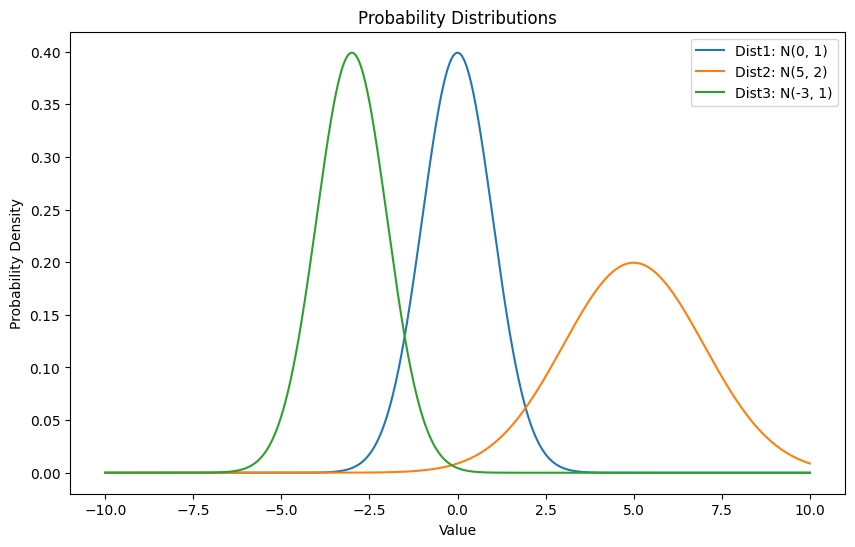

In [378]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Define the distributions
dist1 = norm(loc=0, scale=1)  # Normal distribution with mean 0 and std dev 1
dist2 = norm(loc=5, scale=2)  # Normal distribution with mean 5 and std dev 2
dist3 = norm(loc=-3, scale=1) # Normal distribution with mean -3 and std dev 1

# Generate a range of values
x_values = np.linspace(-10, 10, 1000)

# Calculate the PDF for each distribution
pdf1 = dist1.pdf(x_values)
pdf2 = dist2.pdf(x_values)
pdf3 = dist3.pdf(x_values)

# Plotting the PDFs
plt.figure(figsize=(10, 6))
plt.plot(x_values, pdf1, label='Dist1: N(0, 1)')
plt.plot(x_values, pdf2, label='Dist2: N(5, 2)')
plt.plot(x_values, pdf3, label='Dist3: N(-3, 1)')
plt.title('Probability Distributions')
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.legend()
plt.show()


(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,
         0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  2.,  1.,
         1.,  1.,  4.,  2.,  3.,  1.,  2.,  4.,  3.,  3.,  5.,  7., 10.,
        13., 18., 16., 17., 31., 26., 51., 38., 55., 56., 60., 60., 57.,
        71., 54., 47., 36., 31., 18., 33., 27., 18., 16., 12.,  6.,  8.,
         9.,  5.,  4.,  2.,  4.,  2.,  6.,  1.,  0.,  2.,  3.,  3.,  0.,
         0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.]),
 array([-0.15159242, -0.1486035 , -0.14561458, -0.14262566, -0.13963674,
        -0.13664782, -0.1336589 , -0.13066998, -0.12768106, -0.12469214,
        -0.12170322, -0.1187143 , -0.11572538, -0.11273647, -0.10974755,
        -0.10675863, -0.10376971, -0.10078079, -0.09779187, -0.09480295,
        -0.09181403, -0.08882511, -0.08583619, -0.08284727, -0.07985835,
        -0.07686943, -0.07388051, -0.07089159, -0.06790267, -0.064913

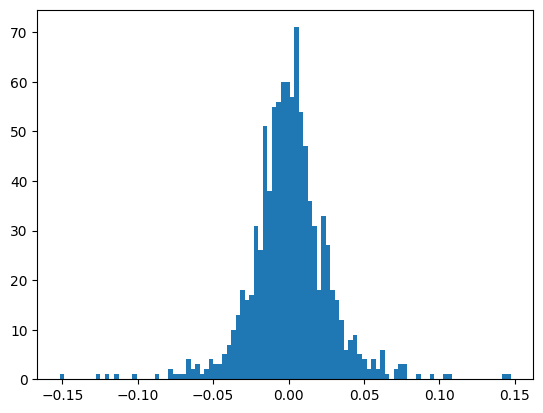

In [382]:
plt.hist(pd.DataFrame(raw_data_np).pct_change(),bins=100)

Means: [ 0.04781034 -0.02152444 -0.05738514 -0.00072739  0.02087517]
Variances: [1.10182843e-03 1.37450995e-04 1.15612784e-03 9.24752205e-05
 1.50718346e-04]


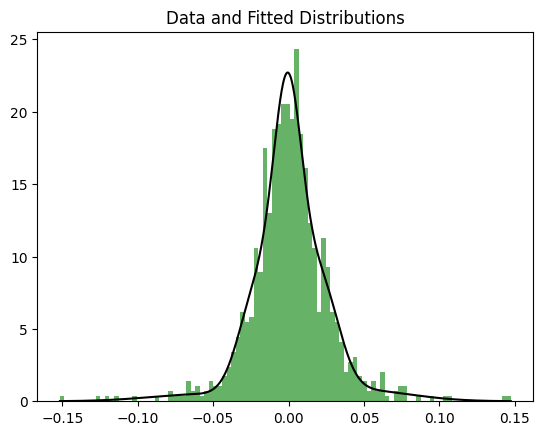

In [418]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

# Example data: You can replace this with your dataset
data = np.random.normal(loc=0, scale=1, size=1000)
data = np.append(data, np.random.normal(loc=5, scale=2, size=1000))
data = data.reshape(-1, 1)  # Reshaping data for the GMM

data = pd.DataFrame(raw_data_np).pct_change().dropna()

def fit_gmm(data, k=5):
    # Choose the number of components
    k = 5  # For example, let's say we want to find 2 distributions

    # Fit a Gaussian Mixture Model
    gmm = GaussianMixture(n_components=k)
    gmm.fit(data)

    return gmm

gmm = fit_gmm(data, k=5)

# Results
print("Means:", gmm.means_.flatten())
print("Variances:", gmm.covariances_.flatten())

# Optional: Plot the data and the distributions
plt.hist(data, bins=100, density=True, alpha=0.6, color='g')

x = np.linspace(np.min(data), np.max(data), 1000).reshape(-1, 1)
logprob = gmm.score_samples(x)
responsibilities = np.exp(logprob)
pdf = np.exp(logprob)
plt.plot(x, pdf, '-k')
plt.title('Data and Fitted Distributions')
plt.show()


In [434]:
def most_likely_distribution(gmm, sample):
    means = {i:v for i, v in enumerate(gmm.means_.flatten())}
    variances = {i:np.sqrt(v) for i, v in enumerate(gmm.covariances_.flatten())}

    # Define the distributions
    dist1 = norm(loc=means[0], scale=variances[0])  # Normal distribution with mean 0 and std dev 1
    dist2 = norm(loc=means[1], scale=variances[1])  # Normal distribution with mean 5 and std dev 2
    dist3 = norm(loc=means[2], scale=variances[2]) # Normal distribution with mean -3 and std dev 1
    dist4 = norm(loc=means[3], scale=variances[3]) # Normal distribution with mean -3 and std dev 1
    dist5 = norm(loc=means[4], scale=variances[4]) # Normal distribution with mean -3 and std dev 1

    # Calculate log likelihood for each distribution
    log_likelihood_1 = calculate_log_likelihood(sample, dist1)
    log_likelihood_2 = calculate_log_likelihood(sample, dist2)
    log_likelihood_3 = calculate_log_likelihood(sample, dist3)
    log_likelihood_4 = calculate_log_likelihood(sample, dist4)
    log_likelihood_5 = calculate_log_likelihood(sample, dist5)

    # Determine which distribution most likely generated the sample
    dist_idx = np.argmax([log_likelihood_1, log_likelihood_2, log_likelihood_3,  log_likelihood_4,  log_likelihood_5])

    return dist_idx, (means[dist_idx], variances[dist_idx])


In [487]:
# List of stock tickers
ticker = 'nvda'

# Time period
start_date = pd.Timestamp('2020-01-01')
end_date = pd.Timestamp.now()

raw_data = get_stock_data(ticker, start_date, end_date)
raw_data_np = clean_data(raw_data)

df = pd.DataFrame(raw_data_np, columns=['price'])
df['returns'] = df['price'].pct_change()
df.dropna(inplace=True)

prices_np = df['price'].values.reshape((-1, 1))
returns_np = df['returns'].values.reshape((-1, 1))

In [490]:
WINDOW_SIZE = 20
SAMPLE_SIZE = prices_np.shape[0]
RETRAIN_FREQ = 200

in_trade = False
balance_list =[]
preds_saved = np.zeros_like(prices_np)

first_train = True

dist_list = []
kl_list = []

balance = 10000
position_percent = 0.1
tm = TradeManager(balance, position_percent)

for i in range(SAMPLE_SIZE-1):
    if i > WINDOW_SIZE:        
        y = get_training_data(returns_np, i-WINDOW_SIZE, WINDOW_SIZE)

        if i % RETRAIN_FREQ == 0 or first_train:
            print('Refitting GMM')
            gmm = fit_gmm(returns_np[:i, :], k=5)
            first_train = False

        dist, stats = most_likely_distribution(gmm, y)
        dist_list.append(stats[0])
        
        if stats[0] < 0.01 and tm.in_trade and tm.long:
            tm.exit_trade(raw_data_np[i])
            balance = tm.balance.item() 
        elif stats[0] > 0.01 and tm.in_trade and not tm.long:
            tm.exit_trade(raw_data_np[i])
            balance = tm.balance.item() 
        elif stats[0] > 0.01 and not tm.in_trade:
            tm.enter_trade(raw_data_np[i], True)
        elif stats[0] < 0.01 and not tm.in_trade:
            tm.enter_trade(raw_data_np[i], False)

        balance_list.append(balance)
        # t_to_retrain -= 1

Refitting GMM
Refitting GMM
Refitting GMM
Refitting GMM
Refitting GMM


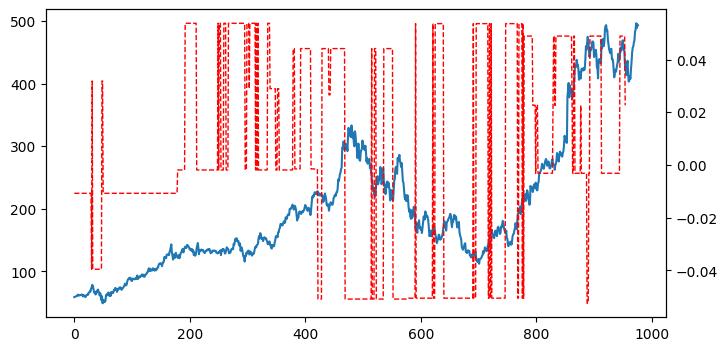

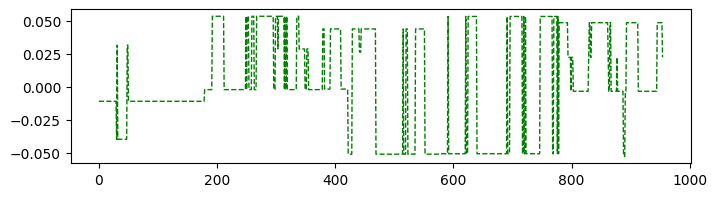

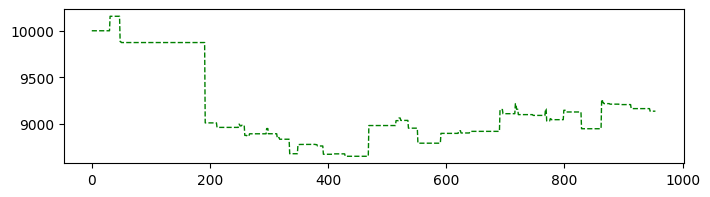

In [491]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(prices_np[:SAMPLE_SIZE, :])
ax2 = ax.twinx()
ax2.plot(dist_list, c='r', linewidth=1.0, linestyle='dashed')
plt.show()

fig, ax = plt.subplots(figsize=(8, 2))
ax.plot(dist_list, c='g', linewidth=1.0, linestyle='dashed')
plt.show()

fig, ax = plt.subplots(figsize=(8, 2))
ax.plot(balance_list, c='g', linewidth=1.0, linestyle='dashed')
plt.show()



### Fourier Analysis

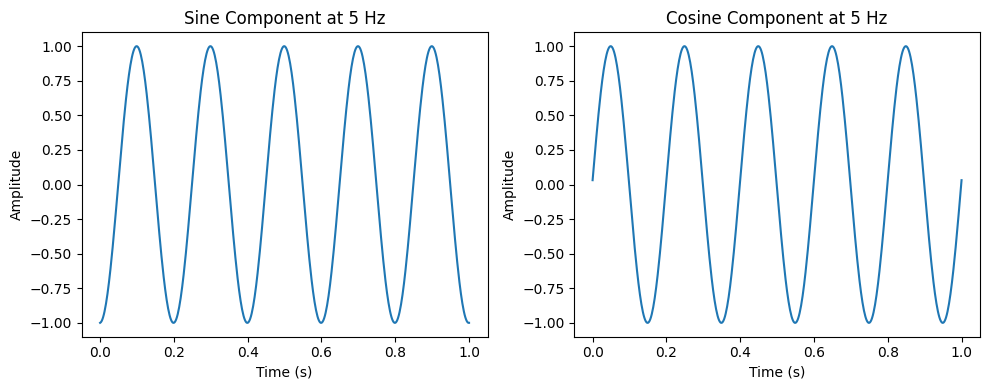

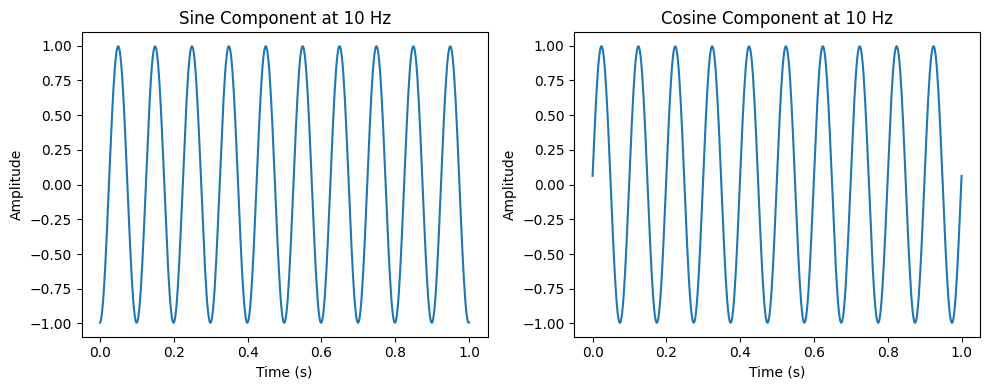

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Example signal
t = np.linspace(0, 1, 500)
signal = np.sin(2 * np.pi * 5 * t) + np.sin(2 * np.pi * 10 * t)

# Fourier Transform
fft_result = np.fft.fft(signal)
n = len(signal)
freq = np.fft.fftfreq(n, d=1/500)

# Applying FFT
fft_result = np.fft.fft(signal)
fft_freq = np.fft.fftfreq(len(signal), d=(t[1]-t[0]))

# Plotting the magnitude spectrum
plt.plot(fft_freq, np.abs(fft_result))
plt.xlim([-20, 20])
plt.title("Magnitude Spectrum")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.show()



In [ ]:
# Identifying significant frequencies
# (For simplicity, this example assumes you have a way to identify these)
significant_freqs = [5, 10]

# Reconstruct and plot individual frequency components
for f in significant_freqs:
    # Get index of the frequency
    index = np.argmin(np.abs(freq - f))
    
    # Extract amplitude and phase
    amplitude = np.abs(fft_result[index]) / n * 2
    phase = np.angle(fft_result[index])
    
    # Reconstruct the individual sine and cosine components
    sine_component = amplitude * np.sin(2 * np.pi * f * t + phase)
    cosine_component = amplitude * np.cos(2 * np.pi * f * t + phase)
    
    # Plotting
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(t, sine_component)
    plt.title(f'Sine Component at {f} Hz')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    
    plt.subplot(1, 2, 2)
    plt.plot(t, cosine_component)
    plt.title(f'Cosine Component at {f} Hz')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    plt.tight_layout()
    plt.show()


### Prophet

In [80]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from datetime import timedelta

In [279]:
def get_stock_data(ticker,
                   start_date,
                   end_date):
    """
    Get stock data from Yahoo Finance.
    """

    # Fetch data        
    stock_data = yf.Ticker(ticker)
    hist_data = stock_data.history(start=start_date, end=end_date)
    hist_data.reset_index(inplace=True)
    hist_data['ds'] = pd.to_datetime(hist_data['Date']).dt.tz_localize(None)
    raw_data = hist_data[['ds', 'Close']]
    raw_data.columns = ['ds', 'y']

    return raw_data

def create_date_range_dataframe(x, a, b):
    """
    Create a DataFrame with a single column 'ds' that contains dates from x - a to x + b.

    :param x: str, Date in 'YYYY-MM-DD' format
    :param a: int, Number of days before x
    :param b: int, Number of days after x
    :return: pandas.DataFrame
    """
    # Convert string to datetime
    base_date = pd.to_datetime(x)

    # Calculate start and end dates
    start_date = base_date - timedelta(days=a)
    end_date = base_date + timedelta(days=b)

    # Generate date range
    dates = pd.date_range(start=start_date, end=end_date, freq='D')

    # Create DataFrame
    df = pd.DataFrame(dates, columns=['ds'])

    return df


In [280]:
# List of stock tickers
ticker = 'tlsa'

# Time period
start_date = pd.Timestamp('2023-09-01')
end_date = pd.Timestamp.now()

raw_data = get_stock_data(ticker, start_date, end_date)
# raw_data_np = clean_data(raw_data)

# df = pd.DataFrame(raw_data_np, columns=['price'])
# df['returns'] = df['price'].pct_change()
# df.dropna(inplace=True)

# prices_np = df['price'].values.reshape((-1, 1))
# returns_np = df['returns'].values.reshape((-1, 1))

In [281]:
# Split the dataset into train and test sets
train_size = int(0.8 * len(raw_data))
train_df = raw_data[:train_size]
test_df = raw_data[train_size:]

# Create and fit the model
model = Prophet()
model.fit(train_df)

# Make future predictions
future = pd.DataFrame(test_df['ds'])
test_pred = model.predict(future)

# Evaluate the model
# Align the forecast with the test set
forecast_test = test_pred.set_index('ds').join(test_df.set_index('ds'))
mae = mean_absolute_error(forecast_test['y'], forecast_test['yhat'])
rmse = np.sqrt(mean_squared_error(forecast_test['y'], forecast_test['yhat']))
print(f'MAE: {mae}, RMSE: {rmse}')

14:31:22 - cmdstanpy - INFO - Chain [1] start processing


14:31:23 - cmdstanpy - INFO - Chain [1] done processing


MAE: 0.06077756575188837, RMSE: 0.06486121576091428


In [282]:
# Plot the results using Plotly
fig = go.Figure()

# Train set
fig.add_trace(go.Scatter(x=train_df['ds'], y=train_df['y'], name='Test Data', mode='lines+markers', line=dict(width=1.0)))

# Test set
fig.add_trace(go.Scatter(x=test_df['ds'], y=test_df['y'], name='Test Data', mode='lines+markers', line=dict(color='green')))

# Predictions
fig.add_trace(go.Scatter(x=test_pred['ds'], y=test_pred['yhat'], mode='lines+markers', 
                         marker=dict(color='red'), name='Predictions'))


# Confidence intervals
fig.add_trace(go.Scatter(x=test_pred['ds'], y=test_pred['yhat_upper'], name='Upper Bound', mode='lines', line=dict(width=0, color='red')))
fig.add_trace(go.Scatter(x=test_pred['ds'], y=test_pred['yhat_lower'], name='Lower Bound', mode='lines', line=dict(width=0, color='red'), fill='tonexty'))


fig.update_layout(title='Prophet Predictions with Confidence Intervals', xaxis_title='Date', yaxis_title='Value')
fig.show()

In [286]:
# Redo the whole next bit so that forecasts and historical stuff are separatedfo9
end_date = raw_data['ds'].max()
pred_window = create_date_range_dataframe(end_date, 7, 7)
forecast = model.predict(pred_window)
forecast = forecast[forecast['ds'].dt.dayofweek < 5]

# Get most recent data
latest_data = raw_data.tail(21)
latest_data = latest_data[latest_data['ds'].dt.dayofweek < 5]

# Plot the results using Plotly
fig = go.Figure()

# Latest Data
fig.add_trace(go.Scatter(x=latest_data['ds'], y=latest_data['y'], name='Test Data', mode='lines+markers'))

# Predictions
# fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='Predictions', mode='lines'))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], mode='markers', 
                         marker=dict(color='red'), name='Predictions'))


# Confidence intervals
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], name='Upper Bound', mode='lines', line=dict(width=0, color='red')))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], name='Lower Bound', mode='lines', line=dict(width=0, color='red'), fill='tonexty'))

fig.update_layout(title='Prophet Predictions with Confidence Intervals', xaxis_title='Date', yaxis_title='Value')
fig.show()


In [274]:
latest_data['ds']

34   2023-10-20
35   2023-10-23
36   2023-10-24
37   2023-10-25
38   2023-10-26
39   2023-10-27
40   2023-10-30
41   2023-10-31
42   2023-11-01
43   2023-11-02
44   2023-11-03
45   2023-11-06
46   2023-11-07
47   2023-11-08
48   2023-11-09
49   2023-11-10
50   2023-11-13
51   2023-11-14
52   2023-11-15
53   2023-11-16
54   2023-11-17
Name: ds, dtype: datetime64[ns]

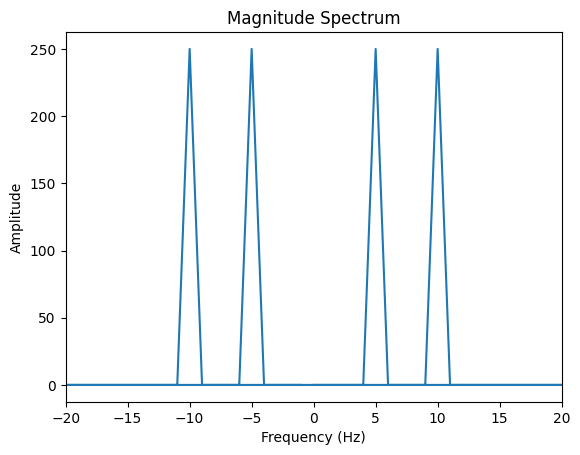

In [211]:
import numpy as np
import matplotlib.pyplot as plt

# Sample signal (you would use your actual data here)
t = np.linspace(0, 1, 500, endpoint=False)
signal = np.sin(2 * np.pi * 5 * t) + np.sin(2 * np.pi * 10 * t)

# Applying FFT
fft_result = np.fft.fft(signal)
fft_freq = np.fft.fftfreq(len(signal), d=(t[1]-t[0]))

# Plotting the magnitude spectrum
plt.plot(fft_freq, np.abs(fft_result))
plt.xlim([-20, 20])
plt.title("Magnitude Spectrum")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.show()


### Generate distributions

In [439]:
# List of stock tickers
ticker = 'FNZ.NZ'

# Time period
start_date = pd.Timestamp('2023-09-01')
end_date = pd.Timestamp.now()

data = get_stock_data(ticker, start_date, end_date, frequency='1d')

In [440]:
data['rtn'] = data['Close'].pct_change()
data.dropna(inplace=True)

mean = data['rtn'].mean()
std_dev = data['rtn'].std()

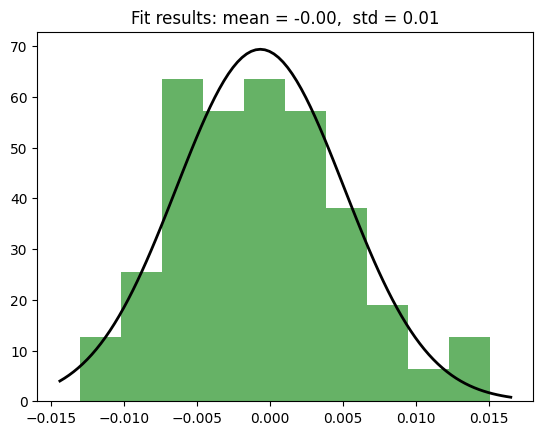

In [441]:
import matplotlib.pyplot as plt
from scipy.stats import norm

# Plot histogram
plt.hist(data['rtn'], bins=10, density=True, alpha=0.6, color='g')

# Plot Gaussian PDF
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean, std_dev)
plt.plot(x, p, 'k', linewidth=2)

title = "Fit results: mean = %.2f,  std = %.2f" % (mean, std_dev)
plt.title(title)

plt.show()


In [442]:
from scipy.stats import kstest

# Kolmogorov-Smirnov test
d, p_value = kstest(data['rtn'], 'norm', args=(mean, std_dev))
print(f"KS statistic: {d}, P-value: {p_value}")


KS statistic: 0.08401113887772904, P-value: 0.7930890846884493


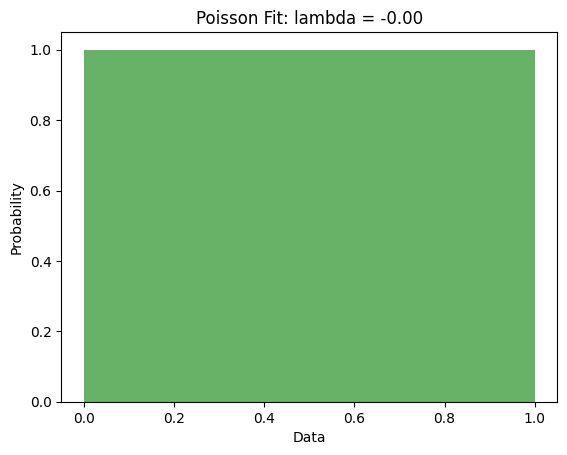

In [445]:
import matplotlib.pyplot as plt
from scipy.stats import poisson

lambda_estimate = mean

# Histogram of the data
plt.hist(data['rtn'], bins=range(int(min(data['rtn'])), int(max(data['rtn'])) + 2), density=True, alpha=0.6, color='g')

# Poisson PMF
x = np.arange(0, int(max(data['rtn'])) + 1)
pmf = poisson.pmf(x, lambda_estimate)
plt.plot(x, pmf, 'k', linewidth=2)

plt.title(f"Poisson Fit: lambda = {lambda_estimate:.2f}")
plt.xlabel("Data")
plt.ylabel("Probability")
plt.show()
